# Titanic Survival Prediction - Using Logistic Regression

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, the ask is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

So we need to create a model that predicts which passengers survived the Titanic shipwreck.

### The solution is divided into the following sections:
- Data understanding and exploration
- Data cleaning.
- Data Analysis.
- Data preparation.
- Model building.
- Prediction and Model evaluation.

## Data understanding and exploration

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import r2_score

from scipy.stats import boxcox


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting Display Max columns and display max rows to None so that it displays all the rows and columns which will 
# help us in initial analysis
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Importing the dataset
data = pd.read_csv("../data/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Checking the dataframe size to understand what amount of data we are dealing with
data.shape

(891, 12)

In [5]:
# Checking the dataframe for the datatypes for all the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Doing describe to check the spread of values across all numerical fields
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Analysis Cleaning and Imputation

In [7]:
# Checking the percentage of missing values across all the columns
round(100*(data[data.columns].isnull().sum()/len(data.index)),2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

In [8]:
# Checking the count/uniqueness of data for Embarked feature
data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

#### Imputing Embarked Value

In [9]:
# Printing the rows with NaN values in Embarked feature
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [10]:
# Replacing the NaN values of Embarked feature with its mode
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

#### Imputing Age

In [11]:
# Checking the spread of data for "Age" feature
data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
# Extracting the salutation from the Name feature
data['Salutation'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [13]:
# Checking the spread of data in Salutation column
data['Salutation'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Don               1
Ms                1
Mme               1
the Countess      1
Sir               1
Capt              1
Jonkheer          1
Lady              1
Name: Salutation, dtype: int64

In [14]:
# Checking the avergae age of passengers across salutation and pclass
print(data.groupby(['Salutation', 'Pclass'])['Age'].agg(['mean']).round(1))

                     mean
Salutation   Pclass      
Capt         1       70.0
Col          1       58.0
Don          1       40.0
Dr           1       43.8
             2       38.5
Jonkheer     1       38.0
Lady         1       48.0
Major        1       48.5
Master       1        5.3
             2        2.3
             3        5.4
Miss         1       30.0
             2       22.4
             3       16.1
Mlle         1       24.0
Mme          1       24.0
Mr           1       41.6
             2       32.8
             3       28.7
Mrs          1       40.9
             2       33.7
             3       33.5
Ms           2       28.0
Rev          2       43.2
Sir          1       49.0
the Countess 1       33.0


In [15]:
# Imputing the missing values of Age with mean age of passengers falling under particular age bracket (filtered with the help 
# of salutation) and then further filtered against pclass, this is done to impute the age of missing passengers with as much
# accuracy as possible
data['Age'] = data.groupby(['Salutation', 'Pclass'])['Age'].transform(lambda x: round(x.fillna(x.mean()),1))

In [16]:
# Creating a age bucket to segregate the age across 4 different age groups
data['Age_bucket'] = pd.cut(data['Age'],[0,12,18,59,100],labels=['Child','Adolescence','Adult','SeniorCitizen'])
# data['Age_bucket'] = pd.cut(data['Age'],[0,10,20,30,40,50,60,70,80],labels=['Child','Adolescence','Adult','SeniorCitizen'])

In [17]:
# Checking the spread of values in Age bucket
data['Age_bucket'].value_counts()

Adult            689
Adolescence      103
Child             73
SeniorCitizen     26
Name: Age_bucket, dtype: int64

In [18]:
# Checking for number of passengers with Salutation "Master" has survived
(data[data['Salutation']=='Master'].Survived==1).value_counts()

True     23
False    17
Name: Survived, dtype: int64

In [19]:
# Created a separate feature named "Master" with values as Yes if the passenger's salutation is master, else No
data['Master'] = np.where(data['Salutation']=='Master','Yes','No')

In [20]:
# Converted the numeric variable to categorical as per data understanding
pclassmap = {1:'Upper',2:'Middle',3:'Lower'}
data['Pclass'] = data['Pclass'].map(pclassmap)

In [21]:
# Checking the spread of data in Parch variable
data['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [22]:
# Checking the spread of data in SibSp variable
data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [23]:
# Created a new feature named "Family" by adding the number of family members of "Parch" and "SibSp"
data['Family'] = data['Parch'] + data['SibSp']

In [24]:
# Created another new feature named "Alone" to capture passengers who were travelling alone
data['Alone'] = np.where(data['Family']==0,'Yes','No')

In [25]:
# Filling the NaN values of Fare with the median of the same
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [26]:
# Creating a Fare bucket to split all the Fares into 'Low','Medium','High','Very High' buckets
data['Fare_bucket'] = pd.qcut(data['Fare'],4, labels=['Low','Medium','High','Very High'])

In [27]:
# Checking the spread of values across Fare buckets
data['Fare_bucket'].value_counts()

Medium       224
Low          223
Very High    222
High         222
Name: Fare_bucket, dtype: int64

In [28]:
# data['Fare_bucket'] = pd.cut(data['Fare'],[0,100,100,30,40,50,60,70,80],labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80'])

In [29]:
# Fare_bucket = ['Low', 'Medium', 'High', 'Very High']
# data['Fare_bucket'] = pd.cut(data['Fare'],
#                               [0, .25, .5, .75, 1],
#                               labels=Fare_bucket)

## Data Analysis

In [30]:
# Created a function to plot bar graph across multiple features
def plotBarGraph(df,xLabel,yLabel,graphSize=[]):
    barData = df.plot(kind="bar",figsize=graphSize)
    barData.set_xlabel(xLabel)
    barData.set_ylabel(yLabel)

    for p in barData.patches:
        barData.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2, p.get_height()), ha='center')

In [31]:
# Printing some rows before proceeding with univariate analysis
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,Age_bucket,Master,Family,Alone,Fare_bucket
0,1,0,Lower,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Adult,No,1,No,Low
1,2,1,Upper,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Adult,No,1,No,Very High
2,3,1,Lower,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Adult,No,0,Yes,Medium
3,4,1,Upper,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Adult,No,1,No,Very High
4,5,0,Lower,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Adult,No,0,Yes,Medium


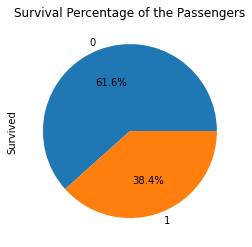

In [32]:
# Plot the percentage of Survived vs Non Survived Cases
# 1 for survived, 0 for deceased
plt.title('Survival Percentage of the Passengers')
data['Survived'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

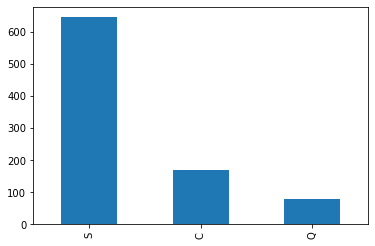

In [33]:
# Checking the spread of values in Embarked feature
data['Embarked'].value_counts().plot.bar()

In [34]:
# Checking the spread of values in Cabin feature
data['Cabin'].value_counts()

B96 B98            4
C23 C25 C27        4
G6                 4
D                  3
F2                 3
E101               3
C22 C26            3
F33                3
B28                2
D20                2
D35                2
B49                2
C125               2
C78                2
B51 B53 B55        2
E8                 2
F4                 2
E121               2
C93                2
B58 B60            2
E25                2
C126               2
C68                2
C65                2
F G73              2
C52                2
E67                2
C124               2
B57 B59 B63 B66    2
C2                 2
B5                 2
E44                2
B20                2
B18                2
C92                2
B22                2
B35                2
E33                2
D26                2
E24                2
D36                2
C83                2
C123               2
D17                2
D33                2
B77                2
A14                1
C49          

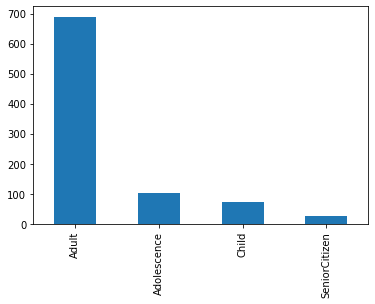

In [35]:
# Checking the spread of values across Age buckets
data['Age_bucket'].value_counts().plot.bar()

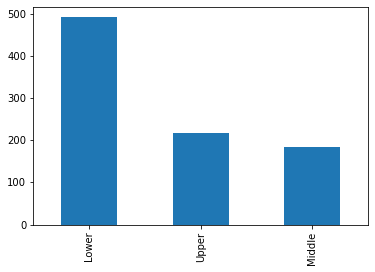

In [36]:
# Checking the spread of values in Pclass feature
data['Pclass'].value_counts().plot.bar()

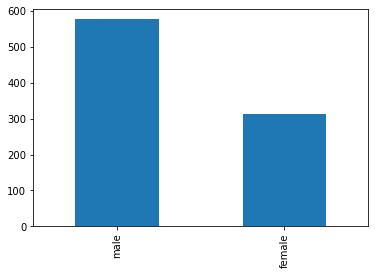

In [37]:
# Checking the spread of values in Sex feature
data['Sex'].value_counts().plot.bar()

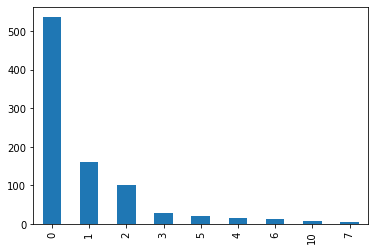

In [38]:
# Checking the spread of values in Family feature
data['Family'].value_counts().plot.bar()

In [39]:
# Checking the spread of values in Family feature
data['Family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

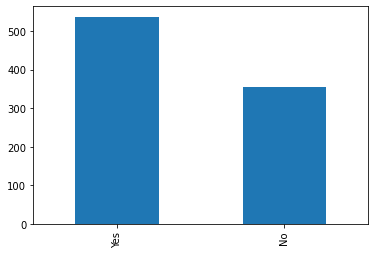

In [40]:
# Checking the spread of values in Alone feature
data['Alone'].value_counts().plot.bar()

In [41]:
# Checking the Fare distribution
data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

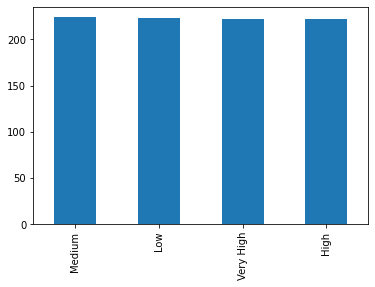

In [42]:
# Checking the spread of values in Fare bucket feature
data['Fare_bucket'].value_counts().plot.bar()

In [43]:
# Checking for variable dtypes and also checking for existence of any null values any further
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    object  
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     891 non-null    object  
 12  Salutation   891 non-null    object  
 13  Age_bucket   891 non-null    category
 14  Master       891 non-null    object  
 15  Family       891 non-null    int64   
 16  Alone        891 non-null    object  
 17  Fare_bucket  891 non-null    category
dtypes: category(2), float64(2), in

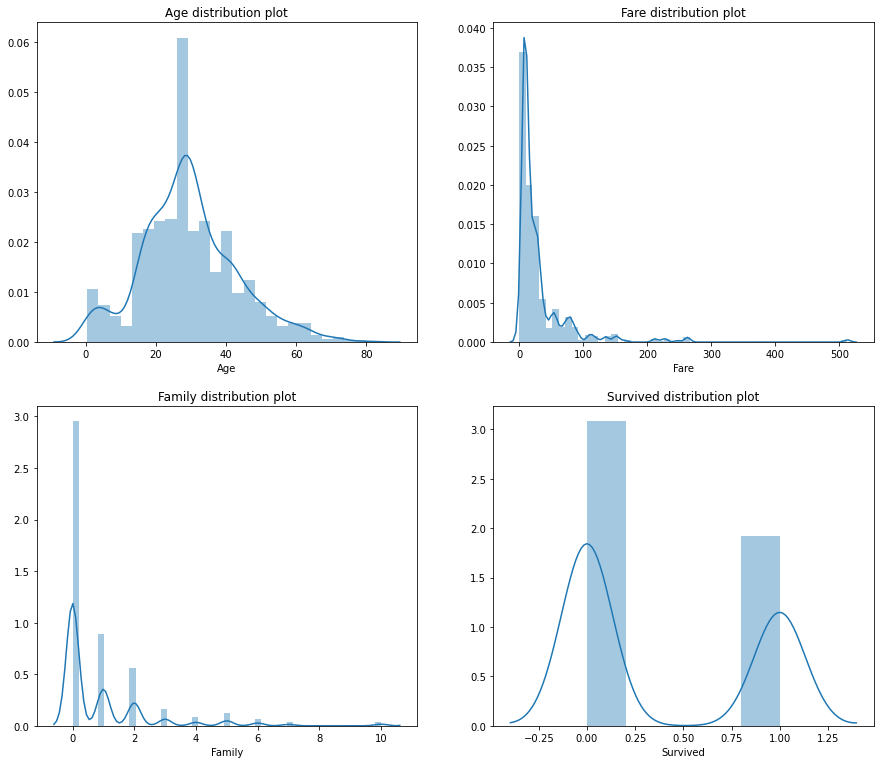

In [44]:
# Plotting the distribution plot for some of variables
cols = ['Age','Fare','Family','Survived']
fig = plt.figure(figsize=(15,20),edgecolor='b')

for i,col in enumerate(cols):
    i=i+1
    plt.subplot(3,2,i)
    plt.title(col+' distribution plot')
    sns.distplot(data[col]) 

In [45]:
# Checking for some of the rows to proceed with further analysis
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,Age_bucket,Master,Family,Alone,Fare_bucket
0,1,0,Lower,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Adult,No,1,No,Low
1,2,1,Upper,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Adult,No,1,No,Very High


In [46]:
# Checking for the distribution of values in Pclass
data.Pclass.value_counts()

Lower     491
Upper     216
Middle    184
Name: Pclass, dtype: int64

Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of class')

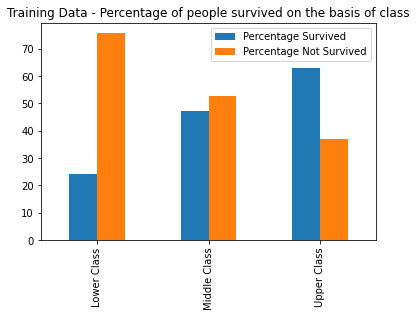

In [47]:
# Checking the Percentage of people survived and Not Survived on the basis of class
pclass_Lower_survivor_dist = round((data[data.Pclass == 'Lower'].Survived == 1).value_counts()[1] / len(data[data.Pclass == 'Lower']) * 100,2)
pclass_Middle_survivor_dist = round((data[data.Pclass == 'Middle'].Survived == 1).value_counts()[1] / len(data[data.Pclass == 'Middle']) * 100,2)
pclass_Upper_survivor_dist = round((data[data.Pclass == 'Upper'].Survived == 1).value_counts()[1] / len(data[data.Pclass == 'Upper']) * 100,2)

pclass_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Lower Class": pclass_Lower_survivor_dist,"Middle Class": pclass_Middle_survivor_dist, "Upper Class": pclass_Upper_survivor_dist},  
     "Percentage Not Survived":{"Lower Class": 100-pclass_Lower_survivor_dist,"Middle Class": 100-pclass_Middle_survivor_dist, "Upper Class": 100-pclass_Upper_survivor_dist}})
pclass_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of class")

In [48]:
# Checking for the distribution of values in Sex
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Training Data - Percentage of male/female survived')

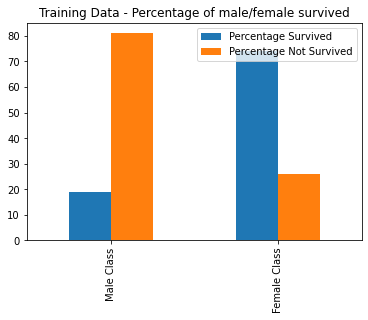

In [49]:
# Checking the Percentage of people survived and Not Survived on the basis of Sex
Sex_male_survivor_dist = round((data[data.Sex == 'male'].Survived == 1).value_counts()[1] / len(data[data.Sex == 'male']) * 100,2)
Sex_female_survivor_dist = round((data[data.Sex == 'female'].Survived == 1).value_counts()[1] / len(data[data.Sex == 'female']) * 100,2)

Sex_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Male Class": Sex_male_survivor_dist,"Female Class": Sex_female_survivor_dist },  
     "Percentage Not Survived":{"Male Class": 100-Sex_male_survivor_dist,"Female Class": 100-Sex_female_survivor_dist}})
Sex_perc_df.plot.bar().set_title("Training Data - Percentage of male/female survived")

In [50]:
# Checking for the distribution of values in Age buckets
data.Age_bucket.value_counts()

Adult            689
Adolescence      103
Child             73
SeniorCitizen     26
Name: Age_bucket, dtype: int64

Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of Age Buckets')

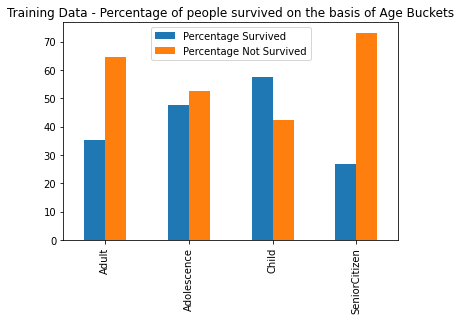

In [51]:
# Checking the Percentage of people survived and Not Survived on the basis of Age buckets
Adult_survivor_dist = round((data[data.Age_bucket == 'Adult'].Survived == 1).value_counts()[1] / len(data[data.Age_bucket == 'Adult']) * 100,2)
Adolescence_survivor_dist = round((data[data.Age_bucket == 'Adolescence'].Survived == 1).value_counts()[1] / len(data[data.Age_bucket == 'Adolescence']) * 100,2)
Child_survivor_dist = round((data[data.Age_bucket == 'Child'].Survived == 1).value_counts()[1] / len(data[data.Age_bucket == 'Child']) * 100,2)
SeniorCitizen_survivor_dist = round((data[data.Age_bucket == 'SeniorCitizen'].Survived == 1).value_counts()[1] / len(data[data.Age_bucket == 'SeniorCitizen']) * 100,2)

Sex_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Adult": Adult_survivor_dist,"Adolescence": Adolescence_survivor_dist,"Child":Child_survivor_dist ,"SeniorCitizen":SeniorCitizen_survivor_dist },  
      "Percentage Not Survived":{"Adult": 100-Adult_survivor_dist,"Adolescence": 100-Adolescence_survivor_dist,"Child":100-Child_survivor_dist ,"SeniorCitizen":100-SeniorCitizen_survivor_dist }})
Sex_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of Age Buckets")

In [52]:
# Checking for the distribution of values in Fare buckets
data.Fare_bucket.value_counts()

Medium       224
Low          223
Very High    222
High         222
Name: Fare_bucket, dtype: int64

Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of Fare Buckets')

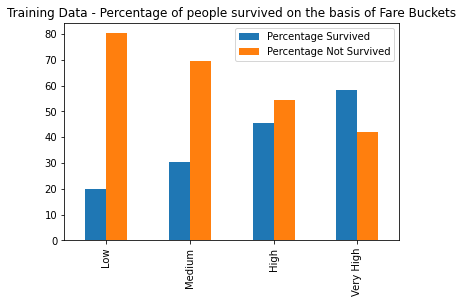

In [53]:
# Checking the Percentage of people survived and Not Survived on the basis of Fare buckets
MediumFare_survivor_dist = round((data[data.Fare_bucket == 'Medium'].Survived == 1).value_counts()[1] / len(data[data.Fare_bucket == 'Medium']) * 100,2)
LowFare_survivor_dist = round((data[data.Fare_bucket == 'Low'].Survived == 1).value_counts()[1] / len(data[data.Fare_bucket == 'Low']) * 100,2)
VeryHighFare_survivor_dist = round((data[data.Fare_bucket == 'Very High'].Survived == 1).value_counts()[1] / len(data[data.Fare_bucket == 'Very High']) * 100,2)
HighFare_survivor_dist = round((data[data.Fare_bucket == 'High'].Survived == 1).value_counts()[1] / len(data[data.Fare_bucket == 'High']) * 100,2)

Fare_bucket_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Low": LowFare_survivor_dist,"Medium": MediumFare_survivor_dist,"High":HighFare_survivor_dist ,"Very High":VeryHighFare_survivor_dist },  
      "Percentage Not Survived":{"Low": 100-LowFare_survivor_dist,"Medium": 100-MediumFare_survivor_dist,"High":100-HighFare_survivor_dist ,"Very High":100-VeryHighFare_survivor_dist }})
Fare_bucket_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of Fare Buckets")

In [54]:
# Checking for the distribution of values in Embark feature
data.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of Embark')

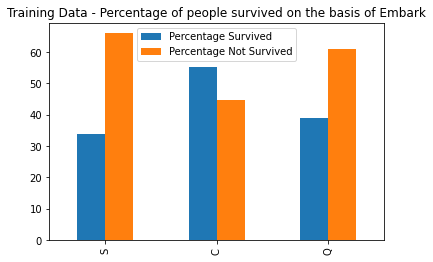

In [55]:
# Checking the Percentage of people survived and Not Survived on the basis of Embark
EmbarkS_survivor_dist = round((data[data.Embarked == 'S'].Survived == 1).value_counts()[1] / len(data[data.Embarked == 'S']) * 100,2)
EmbarkC_survivor_dist = round((data[data.Embarked == 'C'].Survived == 1).value_counts()[1] / len(data[data.Embarked == 'C']) * 100,2)
EmbarkQ_survivor_dist = round((data[data.Embarked == 'Q'].Survived == 1).value_counts()[1] / len(data[data.Embarked == 'Q']) * 100,2)

Embark_perc_df = pd.DataFrame(
    { "Percentage Survived":{"S": EmbarkS_survivor_dist,"C": EmbarkC_survivor_dist,"Q":EmbarkQ_survivor_dist },  
      "Percentage Not Survived":{"S": 100-EmbarkS_survivor_dist,"C": 100-EmbarkC_survivor_dist,"Q":100-EmbarkQ_survivor_dist }})
Embark_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of Embark")

## Data preparation

In [56]:
# Printing some rows from the dataframe
data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,Age_bucket,Master,Family,Alone,Fare_bucket
0,1,0,Lower,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,Adult,No,1,No,Low


In [57]:
# Identified some columns against which new features have been derived or if the feature is not adding any value or 
# there are lot of missing values
cols = ['PassengerId','Name','Age','SibSp','Parch','Ticket','Fare','Cabin','Salutation']
data = data.drop(cols, axis=1)

In [58]:
# Printing a row from the dataframe to check the updated list of columns
data.head(1)

,Survived,Pclass,Sex,Embarked,Age_bucket,Master,Family,Alone,Fare_bucket
0,0,Lower,male,S,Adult,No,1,No,Low


In [59]:
# Converting the Family feature to categorical
data['Family'] = data['Family'].astype('object')

In [60]:
# Removing the Survived feature that is the target feature from the numeric column list as we are going to apply some scaling
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_num_cols = list(data.select_dtypes(include=numerics).columns)
data_num_cols.remove('Survived')
data_num_cols

[]

In [61]:
# Putting all the categorical features in a list
data_cat_cols = list(data.select_dtypes(exclude=numerics).columns)
data_cat_cols

['Pclass',
 'Sex',
 'Embarked',
 'Age_bucket',
 'Master',
 'Family',
 'Alone',
 'Fare_bucket']

In [62]:
# Coverting all the categorical features to dummy variables
data_dummies = pd.get_dummies(data[data_cat_cols], drop_first=True)
data_dummies.head()

,Pclass_Middle,Pclass_Upper,Sex_male,Embarked_Q,Embarked_S,Age_bucket_Adolescence,Age_bucket_Adult,Age_bucket_SeniorCitizen,Master_Yes,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_10,Alone_Yes,Fare_bucket_Medium,Fare_bucket_High,Fare_bucket_Very High
0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [63]:
# Post conversion to dummy variables dropping the original columns against which dummies are created
data = data.drop(list(data_cat_cols), axis=1)

In [64]:
# Concatting all the dummy variables with the original dataframe
data = pd.concat([data, data_dummies], axis=1)
data.head()

,Survived,Pclass_Middle,Pclass_Upper,Sex_male,Embarked_Q,Embarked_S,Age_bucket_Adolescence,Age_bucket_Adult,Age_bucket_SeniorCitizen,Master_Yes,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_10,Alone_Yes,Fare_bucket_Medium,Fare_bucket_High,Fare_bucket_Very High
0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [65]:
# Checking the size of the final dataframe
data.shape

(891, 22)

In [66]:
# Dividing the entire data into X and y that is all independent feature into X and dependent feature to y
X=data
y=data.pop('Survived')

In [67]:
# splitting into train and test set with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Model building

In [68]:
# Created a function to perform and print the VIF
def calc_vif(df):
    vif=pd.DataFrame()
    vif['Features']=df.columns
    vif['VIF']=[variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    print(vif)

In [69]:
# Logistic regression model
log_model = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
log_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      602
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 14 Mar 2021   Deviance:                          nan
Time:                        13:52:32   Pearson chi2:                 4.95e+16
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -8.632e+14   5.13e+06  -1.68e+08      0.000   -8.63e+14   -8.63e+14
Pclass_Middle                1.3251      0.333      3.974      0.000       0.672       1.979
Pclass_Upper                 2.6021      0.486      5.354      0.000       1.650       3.555
Sex_male                    -3.4333      0.276    -12.442      0.000      -3.974      -2.893
Embarked_Q                  -0.8377      0.508     -1.648      0.099      -1.834       0.159
Embarked_S                  -0.6199      0.315     -1.966      0.049      -1.238      -0.002
Age_bucket_Adolescence       0.6391      0.729      0.877      0.381      -0.790       2.068
Age_bucket_Adult            -0.4111      0.666     -0.618      0.537      -1.716       0.893
Age_bucket_SeniorCitizen    -0.3345      0.905     -0.370      0.712      -2.109       1.440
Master_Yes                   3.9027      0.849      4.597      0.000       2.239       5.567
Family_1                  8.632e+14   5.13e+06   1.68e+08      0.000    8.63e+14    8.63e+14
Family_2                  8.632e+14   5.13e+06   1.68e+08      0.000    8.63e+14    8.63e+14
Family_3                  8.632e+14   5.13e+06   1.68e+08      0.000    8.63e+14    8.63e+14
Family_4                  1.238e+15   1.81e+07   6.85e+07      0.000    1.24e+15    1.24e+15
Family_5                  8.632e+14   5.13e+06   1.68e+08      0.000    8.63e+14    8.63e+14
Family_6                  8.632e+14   5.13e+06   1.68e+08      0.000    8.63e+14    8.63e+14
Family_7                  -3.64e+15   3.04e+07   -1.2e+08      0.000   -3.64e+15   -3.64e+15
Family_10                 -3.64e+15   3.04e+07   -1.2e+08      0.000   -3.64e+15   -3.64e+15
Alone_Yes                 8.632e+14   5.13e+06   1.68e+08      0.000    8.63e+14    8.63e+14
Fare_bucket_Medium           0.7180      0.397      1.807      0.071      -0.061       1.497
Fare_bucket_High             0.4548      0.462      0.985      0.324      -0.450       1.359
Fare_bucket_Very High        0.3329      0.613      0.543      0.587      -0.869       1.535
============================================================================================
"""

In [70]:
# Selecting the top 14 significant features using RFE
rfe=RFE(estimator=LogisticRegression(),n_features_to_select=14)  
rfe=rfe.fit(X_train,y_train)

In [71]:
# Print Features and & RFE Ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Pclass_Middle', True, 1),
 ('Pclass_Upper', True, 1),
 ('Sex_male', True, 1),
 ('Embarked_Q', False, 6),
 ('Embarked_S', True, 1),
 ('Age_bucket_Adolescence', False, 3),
 ('Age_bucket_Adult', False, 2),
 ('Age_bucket_SeniorCitizen', True, 1),
 ('Master_Yes', True, 1),
 ('Family_1', True, 1),
 ('Family_2', True, 1),
 ('Family_3', True, 1),
 ('Family_4', True, 1),
 ('Family_5', True, 1),
 ('Family_6', False, 5),
 ('Family_7', True, 1),
 ('Family_10', True, 1),
 ('Alone_Yes', True, 1),
 ('Fare_bucket_Medium', False, 4),
 ('Fare_bucket_High', False, 8),
 ('Fare_bucket_Very High', False, 7)]

In [72]:
# Selecting the top 14 features into a list
select_col = X_train.columns[rfe.support_]
select_col

Index(['Pclass_Middle', 'Pclass_Upper', 'Sex_male', 'Embarked_S',
       'Age_bucket_SeniorCitizen', 'Master_Yes', 'Family_1', 'Family_2',
       'Family_3', 'Family_4', 'Family_5', 'Family_7', 'Family_10',
       'Alone_Yes'],
      dtype='object')

In [73]:
# Build the first model with all the columns selected in RFE
X_rfe = X_train[select_col]
X_train_rfe = sm.add_constant(X_rfe)
log_model_rfe = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial()).fit()
print(log_model_rfe.summary())

#Calculate VIF
calc_vif(X_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      608
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -229.84
Date:                Sun, 14 Mar 2021   Deviance:                       459.68
Time:                        13:52:32   Pearson chi2:                     663.
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [74]:
# Re-Build the model after removing the least significant/high correlated variable
X_rfe = X_rfe.drop('Family_10',axis=1)
X_train_rfe = sm.add_constant(X_rfe)
log_model_rfe = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial()).fit()
print(log_model_rfe.summary())

#Calculate VIF
calc_vif(X_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      609
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -230.76
Date:                Sun, 14 Mar 2021   Deviance:                       461.53
Time:                        13:52:32   Pearson chi2:                     666.
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [75]:
# Re-Build the model after removing the least significant/high correlated variable
X_rfe = X_rfe.drop('Family_7',axis=1)
X_train_rfe = sm.add_constant(X_rfe)
log_model_rfe = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial()).fit()
print(log_model_rfe.summary())

#Calculate VIF
calc_vif(X_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      610
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -232.04
Date:                Sun, 14 Mar 2021   Deviance:                       464.07
Time:                        13:52:32   Pearson chi2:                     669.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [76]:
# Re-Build the model after removing the least significant/high correlated variable
X_rfe = X_rfe.drop('Age_bucket_SeniorCitizen',axis=1)
X_train_rfe = sm.add_constant(X_rfe)
log_model_rfe = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial()).fit()
print(log_model_rfe.summary())

#Calculate VIF
calc_vif(X_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      611
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -232.60
Date:                Sun, 14 Mar 2021   Deviance:                       465.20
Time:                        13:52:32   Pearson chi2:                     673.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8962      0.775     -1.156

In [77]:
# Re-Build the model after removing the least significant/high correlated variable
X_rfe = X_rfe.drop('Family_4',axis=1)
X_train_rfe = sm.add_constant(X_rfe)
log_model_rfe = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial()).fit()
print(log_model_rfe.summary())

#Calculate VIF
calc_vif(X_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      612
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -233.26
Date:                Sun, 14 Mar 2021   Deviance:                       466.53
Time:                        13:52:32   Pearson chi2:                     675.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.4585      0.660     -2.209

In [78]:
# Re-Build the model after removing the least significant/high correlated variable
X_rfe = X_rfe.drop('Family_5',axis=1)
X_train_rfe = sm.add_constant(X_rfe)
log_model_rfe = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial()).fit()
print(log_model_rfe.summary())

#Calculate VIF
calc_vif(X_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      613
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -233.68
Date:                Sun, 14 Mar 2021   Deviance:                       467.36
Time:                        13:52:32   Pearson chi2:                     674.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.7741      0.599     -2.963

In [79]:
# Re-Build the model after removing the least significant/high correlated variable
X_rfe = X_rfe.drop('Embarked_S',axis=1)
X_train_rfe = sm.add_constant(X_rfe)
log_model_rfe = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial()).fit()
print(log_model_rfe.summary())

#Calculate VIF
calc_vif(X_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  623
Model:                            GLM   Df Residuals:                      614
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -234.74
Date:                Sun, 14 Mar 2021   Deviance:                       469.48
Time:                        13:52:33   Pearson chi2:                     664.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.1153      0.549     -3.850

## Prediction and Model evaluation

In [80]:
# Initialise Logistic Regression model & fit the model with the final set of variables
logreg = LogisticRegression()
logreg.fit(X_train[X_rfe.columns], y_train)
y_test_pred=logreg.predict(X_test[X_rfe.columns])

In [81]:
# Printing the coefficients of each feature
logreg.coef_

array([[ 0.95044008,  1.83757448, -2.93866144,  2.66345533,  1.24500855,
         1.41028509,  1.50284339,  1.18573338]])

In [82]:
# Putting the coefficients and its associated features in a dataframe
model_df = pd.DataFrame({'Columns':X_rfe.columns, 'Coefficients':logreg.coef_[0]})
model_df = model_df.sort_values(by='Coefficients',ascending=False)
model_df

,Columns,Coefficients
3,Master_Yes,2.663455
1,Pclass_Upper,1.837574
6,Family_3,1.502843
5,Family_2,1.410285
4,Family_1,1.245009
7,Alone_Yes,1.185733
0,Pclass_Middle,0.950440
2,Sex_male,-2.938661


In [83]:
# Print Accurcy on the Test Set
print('Accuracy for Test:',round(accuracy_score(y_test,y_test_pred),2)*100)

Accuracy for Test: 80.0


In [84]:
# Getting the predicted values on the train set
y_train_pred=logreg.predict(X_train[X_rfe.columns])

In [85]:
# Print Accurcy on the Train Set
print('Accuracy for Train:',round(accuracy_score(y_train,y_train_pred),2)*100)

Accuracy for Train: 85.0


## So we have a training accuracy of 85% and test accuracy of 80%

## Now lets proceed with the preparation for the final submission. 
## First lets do the data preparation of the final Test Data provided for predictions.
## [For final submission and evaluation]

In [86]:
# Importing dataset
data_test = pd.read_csv("../data/test.csv")
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [87]:
# Checking the size of the test set
data_test.shape

(418, 11)

In [88]:
# Checking for null values and dtypes
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [89]:
# Checking for percentage of missing values
round(100*(data_test[data_test.columns].isnull().sum()/len(data_test.index)),2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin          78.23
Embarked        0.00
dtype: float64

#### Imputing Age

In [90]:
# Extracting the salutation from Name feature and creating a new feature named Salutation
data_test['Salutation'] = data_test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [91]:
# Checking the distribution of data in Salutation
data_test['Salutation'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Salutation, dtype: int64

In [92]:
# Priting average age of passengers spread across salutation and pclass
print(data_test.groupby(['Salutation', 'Pclass'])['Age'].agg(['mean']).round(1))

                   mean
Salutation Pclass      
Col        1       50.0
Dona       1       39.0
Dr         1       53.0
Master     1        9.5
           2        5.0
           3        7.5
Miss       1       31.4
           2       17.4
           3       19.9
Mr         1       41.2
           2       31.7
           3       27.2
Mrs        1       45.6
           2       33.0
           3       29.9
Ms         3        NaN
Rev        2       35.5


In [93]:
# Imputing the missing values of Age with mean age of passengers falling under particular age bracket (filtered with the help 
# of salutation) and then further filtered against pclass, this is done to impute the age of missing passengers with as much
# accuracy as possible
data_test['Age'] = data_test.groupby(['Salutation', 'Pclass'])['Age'].transform(lambda x: round(x.fillna(x.mean()),1))

In [94]:
# Creating age buckets to convert age feature from numeric to categorical
data_test['Age_bucket'] = pd.cut(data_test['Age'],[0,12,18,59,100],labels=['Child','Adolescence','Adult','SeniorCitizen'])

In [95]:
# Checking the spread of data in age bucket feature
data_test['Age_bucket'].value_counts()

Adult            345
Adolescence       29
Child             29
SeniorCitizen     14
Name: Age_bucket, dtype: int64

In [96]:
# Checking number of records with Salutation as Master
(data_test['Salutation']=='Master').value_counts()

False    397
True      21
Name: Salutation, dtype: int64

In [97]:
# Creating a new derived feature as Master, having values as Yes if the salutation for that record is master or else No
data_test['Master'] = np.where(data_test['Salutation']=='Master','Yes','No')

In [98]:
# Mapping the Pclass feature with respective values as per data understanding
pclassmap = {1:'Upper',2:'Middle',3:'Lower'}
data_test['Pclass'] = data_test['Pclass'].map(pclassmap)

In [99]:
# Checking for distribution of Parch values
data_test['Parch'].value_counts()

0    324
1     52
2     33
3      3
9      2
4      2
6      1
5      1
Name: Parch, dtype: int64

In [100]:
# Checking for distribution of SibSp values
data_test['SibSp'].value_counts()

0    283
1    110
2     14
4      4
3      4
8      2
5      1
Name: SibSp, dtype: int64

In [101]:
# Creating a derived feature "Family" by adding the values of Parch and SibSp
data_test['Family'] = data_test['Parch'] + data_test['SibSp']

In [102]:
# Creating a derived feature "Alone" with value as Yes where the Passenger's Family feature value is 0 and No otherwise
data_test['Alone'] = np.where(data_test['Family']==0,'Yes','No')

In [103]:
# Filling the missing values of Fare with median of the same as per data understanding
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].median())

In [104]:
# Splitting the Fare across buckets
data_test['Fare_bucket'] = pd.qcut(data_test['Fare'],4, labels=['Low','Medium','High','Very High'])

In [105]:
# Checking for spread of data of Fare bucket
data_test['Fare_bucket'].value_counts()

Low          114
Very High    105
High         102
Medium        97
Name: Fare_bucket, dtype: int64

In [106]:
# Just printing a row to get a sense of all the features present now
data_test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,Age_bucket,Master,Family,Alone,Fare_bucket
0,892,Lower,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,Adult,No,0,Yes,Low


In [107]:
# Identified some columns against which new features have been derived or if the feature is not adding any value or 
# there are lot of missing values
cols = ['Name','Age','SibSp','Parch','Ticket','Fare','Cabin','Salutation']
data_test = data_test.drop(cols, axis=1)

In [108]:
# CHecking the dataframe post deletion
data_test.head(1)

,PassengerId,Pclass,Sex,Embarked,Age_bucket,Master,Family,Alone,Fare_bucket
0,892,Lower,male,Q,Adult,No,0,Yes,Low


In [109]:
# Converting the Family feature to categorical
data_test['Family'] = data_test['Family'].astype('object')

In [110]:
# Identifying and putting the names of all numeric columns under one list
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
datatest_num_cols = list(data_test.select_dtypes(include=numerics).columns)
datatest_num_cols

['PassengerId']

In [111]:
# Identifying and putting the names of all categorical columns under one list
datatest_cat_cols = list(data_test.select_dtypes(exclude=numerics).columns)
datatest_cat_cols

['Pclass',
 'Sex',
 'Embarked',
 'Age_bucket',
 'Master',
 'Family',
 'Alone',
 'Fare_bucket']

In [112]:
# Creating dummies against all the categorical features
datatest_dummies = pd.get_dummies(data_test[datatest_cat_cols], drop_first=True)
datatest_dummies.head()

,Pclass_Middle,Pclass_Upper,Sex_male,Embarked_Q,Embarked_S,Age_bucket_Adolescence,Age_bucket_Adult,Age_bucket_SeniorCitizen,Master_Yes,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_10,Alone_Yes,Fare_bucket_Medium,Fare_bucket_High,Fare_bucket_Very High
0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
3,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [113]:
# Dropping all the columns against which dummy variables are created
data_test = data_test.drop(list(datatest_cat_cols), axis=1)

In [114]:
# Concatting all the dummy variables with the original dataframe
data_test = pd.concat([data_test, datatest_dummies], axis=1)
data_test.head()

,PassengerId,Pclass_Middle,Pclass_Upper,Sex_male,Embarked_Q,Embarked_S,Age_bucket_Adolescence,Age_bucket_Adult,Age_bucket_SeniorCitizen,Master_Yes,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_10,Alone_Yes,Fare_bucket_Medium,Fare_bucket_High,Fare_bucket_Very High
0,892,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,893,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,894,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
3,895,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,896,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [115]:
# Checking the shape of the final dataframe
data_test.shape

(418, 22)

In [116]:
# Further shortlisting the significant columns only as per the model created above
final_test = data_test[X_rfe.columns]

In [117]:
# Printing the final set of columns
final_test.columns

Index(['Pclass_Middle', 'Pclass_Upper', 'Sex_male', 'Master_Yes', 'Family_1',
       'Family_2', 'Family_3', 'Alone_Yes'],
      dtype='object')

In [118]:
# Using the model object created earlier, predicting the target values with the help of the test data and finally creating a
# dataframe with the passengerID and the survival prediction and then saving the same in an excel for submission
result = logreg.predict(final_test)
submission = pd.DataFrame({'PassengerId':data_test.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic Predictions.csv
